In [ ]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DataSets/carprice.csv")


Kütüphaneler yüklendi.
Veri seti başarıyla yüklendi.
Veri temizlendi. İlk 5 satır:
   car_ID  symboling fueltype aspiration doornumber      carbody drivewheel  \
0       1          3      gas        std        two  convertible        rwd   
1       2          3      gas        std        two  convertible        rwd   
2       3          1      gas        std        two    hatchback        rwd   
3       4          2      gas        std       four        sedan        fwd   
4       5          2      gas        std       four        sedan        4wd   

  enginelocation  wheelbase  carlength  ...  fuelsystem  boreratio  stroke  \
0          front       88.6      168.8  ...        mpfi       3.47    2.68   
1          front       88.6      168.8  ...        mpfi       3.47    2.68   
2          front       94.5      171.2  ...        mpfi       2.68    3.47   
3          front       99.8      176.6  ...        mpfi       3.19    3.40   
4          front       99.4      176.6  ...        m

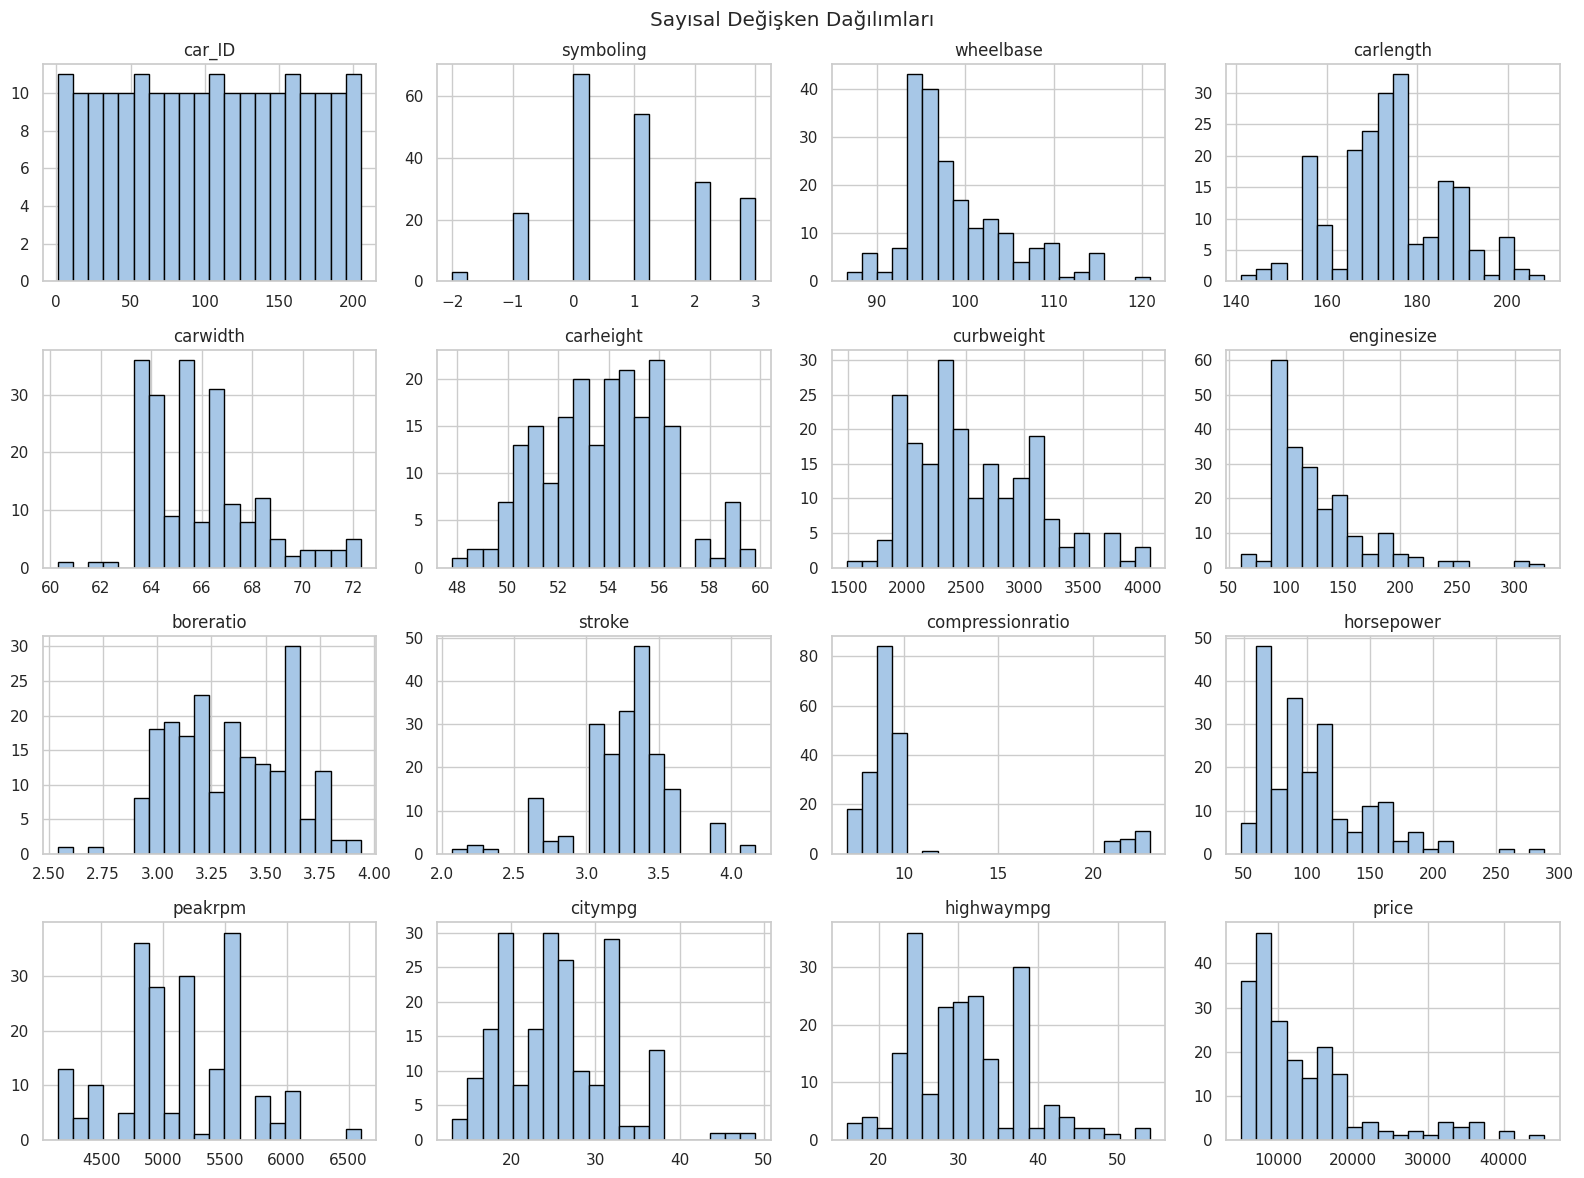

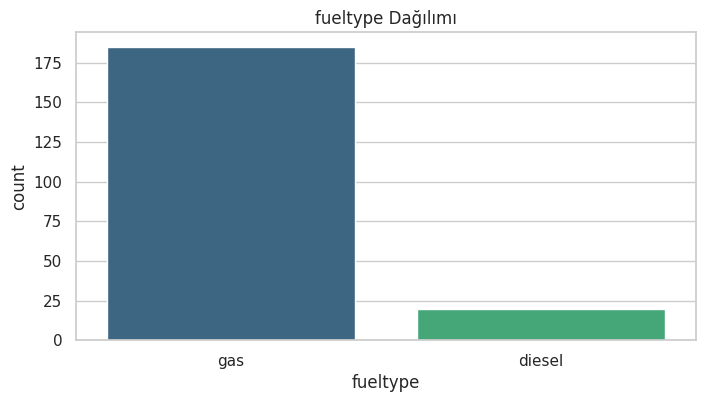

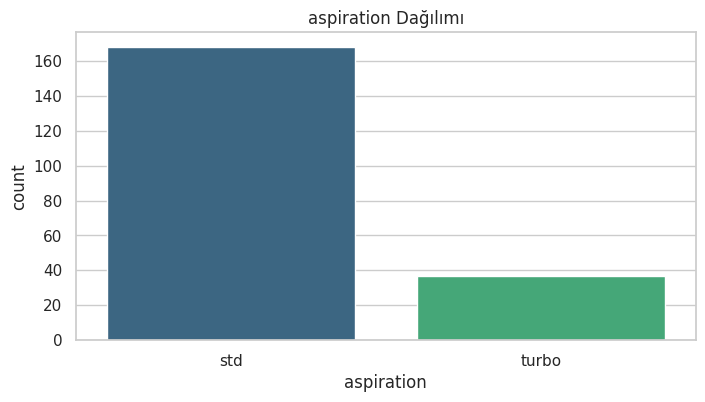

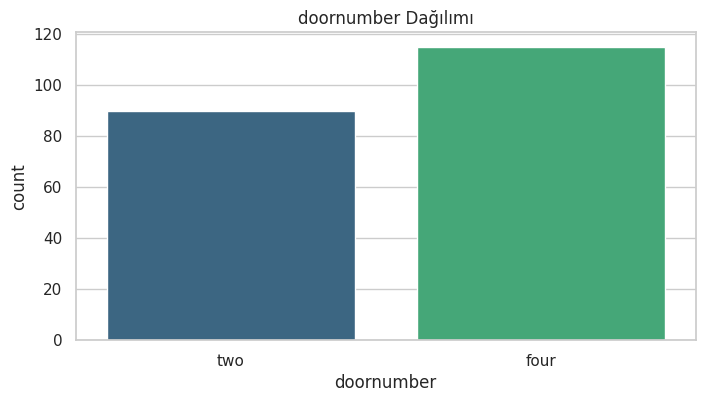

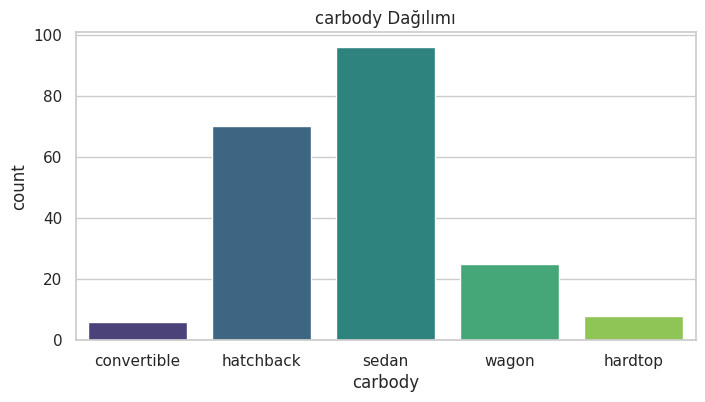

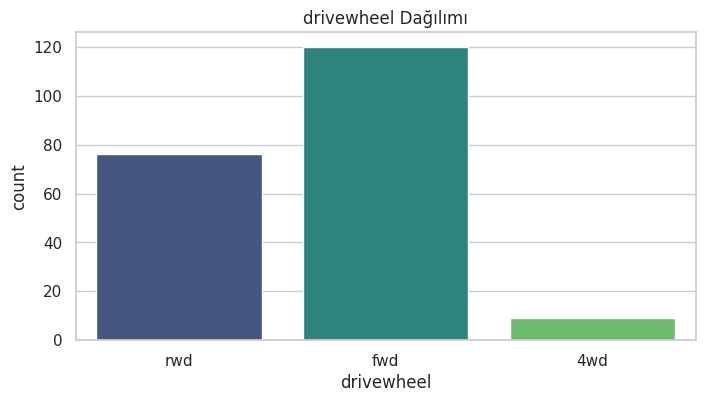

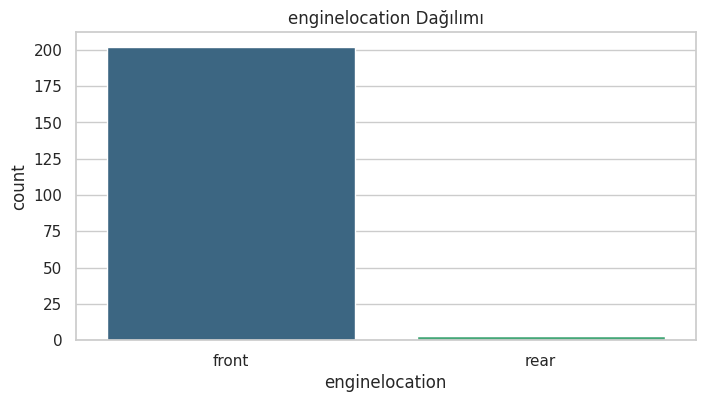

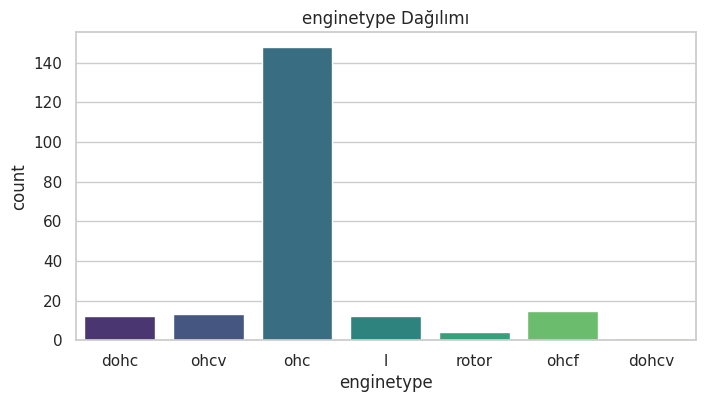

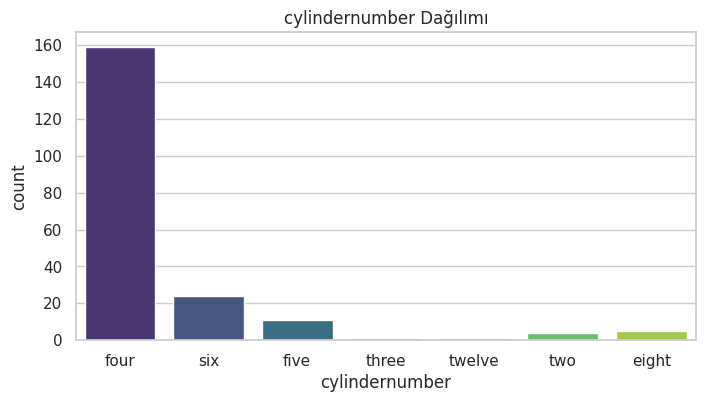

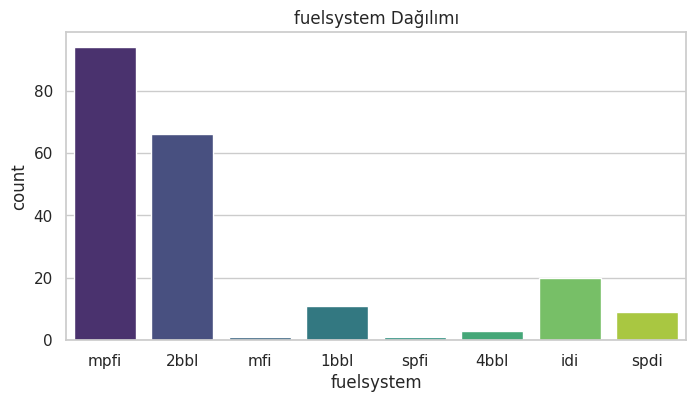

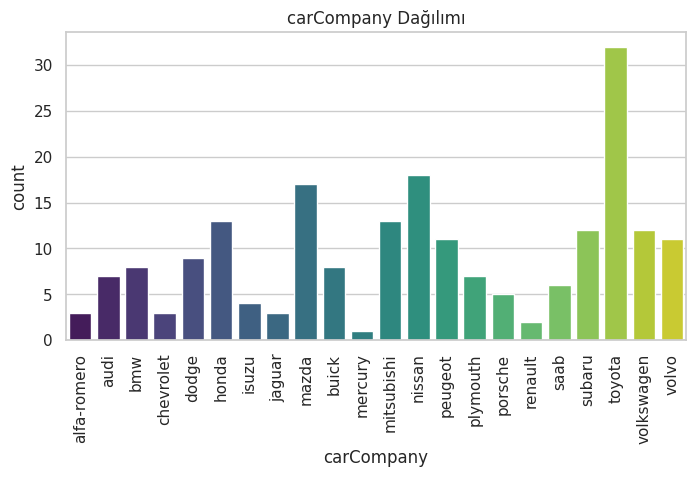

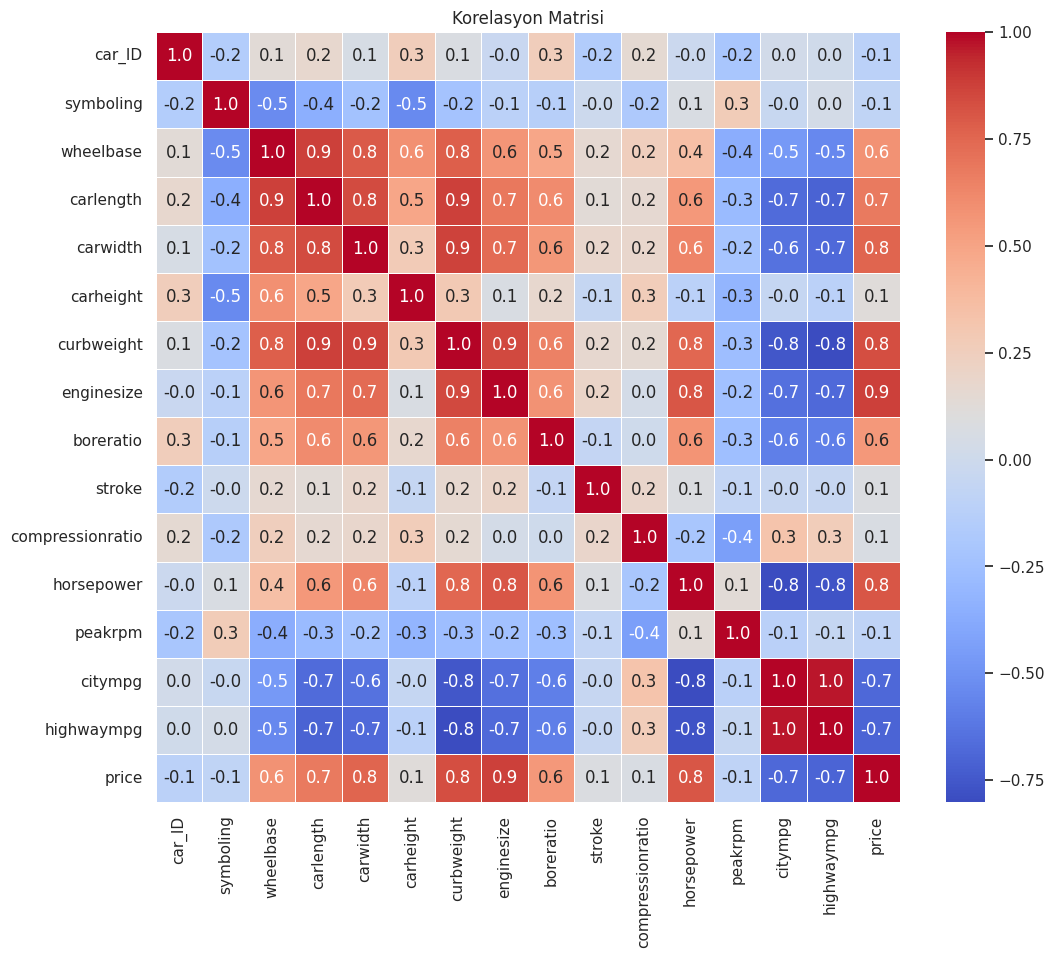


--- Model Eğitiliyor ---

------------------------------
MODEL PERFORMANSI
------------------------------
MAE (Ortalama Hata): 1806.44
R2 Score (Başarı Skoru): 0.9008
------------------------------


In [ ]:
# =========================================================
# 1. AYARLAR VE KÜTÜPHANELER
# =========================================================
# Grafikleri satır içinde göstermek için sihirli komut:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Görselleştirme teması
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams["figure.figsize"] = (10,6)

print("Kütüphaneler yüklendi.")


# =========================================================
# 2. VERİ SETİNİ YÜKLE
# =========================================================
csv_path = "/content/carprice.csv"

try:
    df = pd.read_csv(csv_path)
    print("Veri seti başarıyla yüklendi.")
except FileNotFoundError:
    print("Hata: 'carprice.csv' dosyası bulunamadı. Lütfen dosyayı Colab'e yüklediğinden emin ol.")

# =========================================================
# 3. VERİ TEMİZLEME
# =========================================================
# Marka ve Model ayrımı
if "CarName" in df.columns:
    df["carCompany"] = df["CarName"].apply(lambda x: x.split(" ")[0].lower())

    # Hatalı yazımları düzeltme
    df["carCompany"] = df["carCompany"].replace({
        "vw":"volkswagen",
        "vokswagen":"volkswagen",
        "toyouta":"toyota",
        "porcshce":"porsche",
        "Nissan":"nissan",
        "maxda": "mazda"
    })

    # Gereksiz kolonu düşürme
    df = df.drop(columns=["CarName"])

print("Veri temizlendi. İlk 5 satır:")
print(df.head())


# =========================================================
# 4. GÖRSELLEŞTİRME (EDA)
# =========================================================
print("\n--- Grafikler Hazırlanıyor ---\n")

# 4a. Sayısal Değişkenler (Histogram)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols].hist(figsize=(16, 12), color="#a7c7e7", bins=20, edgecolor="black")
plt.suptitle("Sayısal Değişken Dağılımları")
plt.tight_layout()
plt.show()  # Grafiği ekrana bas

# 4b. Kategorik Değişkenler (Countplot)
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    # Çok fazla kategori varsa (örn: marka) yazıları dik çevir
    if df[col].nunique() > 10:
        plt.xticks(rotation=90)

    sns.countplot(x=df[col], hue=df[col], palette="viridis", legend=False)
    plt.title(f"{col} Dağılımı")
    plt.show() # Her döngüde grafiği göster

# 4c. Korelasyon Isı Haritası
plt.figure(figsize=(12, 10))
corr = df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)
plt.title("Korelasyon Matrisi")
plt.show()


# =========================================================
# 5. MODELLEME
# =========================================================
print("\n--- Model Eğitiliyor ---\n")

X = df.drop(columns=["price"])
y = df["price"]

numeric_features = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# --- HATA DÜZELTMESİ ---
# handle_unknown="ignore" eklendi.
# drop="first" kaldırıldı (ignore ile çakışmaması için).
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)

model = LinearRegression()

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modeli eğit
pipe.fit(X_train, y_train)

# Tahmin
y_pred = pipe.predict(X_test)


# =========================================================
# 6. SONUÇLAR
# =========================================================
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("-" * 30)
print("MODEL PERFORMANSI")
print("-" * 30)
print(f"MAE (Ortalama Hata): {mae:.2f}")
print(f"R2 Score (Başarı Skoru): {r2:.4f}")
print("-" * 30)